In [1]:
from minio import Minio
import s3fs
import os
import matplotlib.pyplot as plt
import xarray as xr
import pickle
import numpy as np

fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "http://192.168.1.237:9000"
    },
    key="d0d250b2541ac33f4660",
    secret="2fb32d964768bc94a3c0"
)
output_dir='/home/scratch/Abel_data/hw_processed/ctrl/'

In [9]:
output_file=output_dir+'thresh95'
with open(output_file, 'rb') as f:
    thresh=pickle.load(f)
# print(thresh)

def identify_heatwaves(latc):
    
    hw_index=1
    hw_master={'index':[],'run':[],'time':[], 'T':[], 'lonc':[],
              'intensity':[], 'duration':[], 'maximum':[]}
    lon_ind=np.arange(35)*10+10
    print(lon_ind)
    for ln in lon_ind[::5]:
        
        print(ln)
        
        for r in range(1,3):
            t_run=[]
            for y in range(1,21):

                # Path inside the bucket to your Zarr store
                zarr_path = "abel-long-run/Regridded_data/run"+str(r)+"/year"+str(y)
                ds = xr.open_zarr(fs.get_mapper(zarr_path))

                t_run.append(ds['air_temperature'].sel({'lev': 98000, 'lat':slice(latc+5, latc-5), 'lon':slice(ln-5, ln+5)}))

            t_run=xr.merge(t_run, compat='no_conflicts', join='outer')
            t_run=t_run.weighted(np.cos(np.radians(t_run.lat))).mean(dim=('lat', 'lon'))['air_temperature']-thresh[latc]
            
            # for loop to find heatwaves - there may be a better way to do this!
            
            temp_time=[]
            temp_intensity=[]
            l_curr=0
            for i in range(1, len(t_run)):
                if t_run[i]>0:
                    if len(temp_time)==0:
                        temp_time.append(t_run.time[i-1]); temp_intensity.append(t_run[i-1]) 
                    temp_time.append(t_run.time[i]); temp_intensity.append(t_run[i]) 
                    l_curr=l_curr+1
                else:
                    if l_curr>=3:
                        temp_time.append(t_run.time[i]); temp_intensity.append(t_run[i]) 
                        
                        temp_time = np.array([t.values for t in temp_time])
                        temp_intensity = np.array([t.values for t in temp_intensity])
                        heat=temp_intensity.copy()
                
                        st=1-heat[0]/(heat[0]-heat[1]); end=heat[-2]/(heat[-2]-heat[-1])
                        heat[0]=0;heat[-1]=0
                        dur_weight=np.ones(len(heat)-1); dur_weight[0]=st;dur_weight[-1]=end
                        intensity=np.average((heat[1:]+heat[:-1])/2,weights=dur_weight)
                        mx=np.max(heat[1:-1])
                        dur=len(heat[1:-1])-1+st+end

                        if dur>=3:
                            hw_master['index'].append(hw_index)
                            hw_master['run'].append(r)
                            hw_master['time'].append(temp_time)
                            hw_master['T'].append(temp_intensity)
                            hw_master['intensity'].append(intensity.item())
                            hw_master['duration'].append(dur.item())
                            hw_master['maximum'].append(mx.item())
                            hw_master['lonc'].append(ln.item())
                            hw_index=hw_index+1
                            

                    l_curr=0
                    temp_intensity=[]
                    temp_time=[]
                    
    print(hw_master['index'][-1])
    output_file=output_dir+'hw_'+str(latc)
    if not os.path.isfile(output_file):
        with open(output_file, 'wb') as f:
            pickle.dump(hw_master, f)

identify_heatwaves(45)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350]
10


/tmp/ipykernel_2712600/3991444134.py:23: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(fs.get_mapper(zarr_path))


<xarray.Dataset> Size: 2GB
Dimensions:                                   (time: 365, mid_levels: 28,
                                               lat: 64, lon: 128)
Coordinates:
  * time                                      (time) datetime64[ns] 3kB 2004-...
Dimensions without coordinates: mid_levels, lat, lon
Data variables: (12/13)
    air_temperature                           (time, mid_levels, lat, lon) float32 335MB ...
    eastward_wind                             (time, mid_levels, lat, lon) float32 335MB ...
    air_pressure                              (time, mid_levels, lat, lon) float32 335MB ...
    boundary_layer_height                     (time, lat, lon) float32 12MB ...
    divergence_of_wind                        (time, mid_levels, lat, lon) float32 335MB ...
    specific_humidity                         (time, mid_levels, lat, lon) float32 335MB ...
    ...                                        ...
    northward_wind                            (time, mid_levels, l

KeyError: "'lev' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'time': 365, 'mid_levels': 28, 'lat': 64, 'lon': 128})"

1.4593951374053402


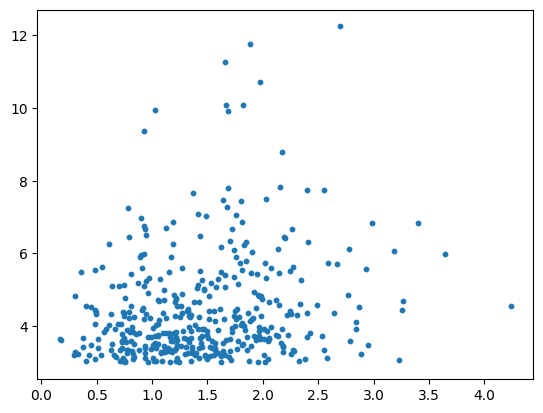

In [12]:
output_file=output_dir+'hw_temp_50'
with open(output_file, 'rb') as f:
    hw_master=pickle.load(f)

print(np.mean(hw_master['intensity']))
plt.scatter(hw_master['intensity'], hw_master['duration'], s=10)

In [4]:
# computing thresholds for heatwave identification

def compute_threshold():
    
    lat_c=[20,25,30,35,40,45,50,55,60]
#     lat_c=[20, 25, 30]
    thresh={}
    
    for l in lat_c:
        print(l)
        
        t_all=[]
        for r in range(1,51):
            t_run=[]
            for y in range(1,21):

                # Path inside the bucket to your Zarr store
                zarr_path = "abel-long-run/Regridded_data/run"+str(r)+"/year"+str(y)
                ds = xr.open_zarr(fs.get_mapper(zarr_path))

                t_run.append(ds['air_temperature'].sel({'lev': 98000, 'lat':slice(l+5, l-5), 'lon':slice(100, 110)}))
        
            t_run=xr.merge(t_run, compat='no_conflicts', join='outer')
            t_run=t_run.weighted(np.cos(np.radians(t_run.lat))).mean(dim=('lat', 'lon'))
            t_all.append(t_run)

        thresh[l]=xr.concat(t_all, dim="run")['air_temperature'].quantile(0.95, dim=('run', 'time')).item()
    
    print(thresh)
    output_file=output_dir+'thresh95'
    if not os.path.isfile(output_file):
        with open(output_file, 'wb') as f:
            pickle.dump(thresh, f)

        
compute_threshold()

20
25
30
35
40
45
50
55
60
{20: 300.4913134192718, 25: 299.6883793627682, 30: 297.8156659567635, 35: 296.3853769835471, 40: 294.1392268447098, 45: 292.05825909456536, 50: 289.2057581869941, 55: 286.0739241370783, 60: 283.3309891985821}


In [ ]:
## if you want to use the lowest model level temperature for the heatwave identification

In [14]:
output_file=output_dir+'thresh95_temp'
with open(output_file, 'rb') as f:
    thresh=pickle.load(f)
# print(thresh)

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat_g=common['latitude'].values[:,0]
lon_g=common['longitude'].values[0,:]

def identify_heatwaves(latc):
    
    hw_index=1
    hw_master={'index':[],'run':[],'time':[], 'T':[], 'lonc':[],
              'intensity':[], 'duration':[], 'maximum':[]}
    lon_ind=np.array([105])#np.arange(35)*10+10
    print(lon_ind)
    for ln in lon_ind:
        
        print(ln)
        
        for r in range(1,51):
            t_run=[]
            for y in range(1,21):

                # Path inside the bucket to your Zarr store
                zarr_path = "abel-long-run/long_run_data/run"+str(r)+"/year"+str(y)
                ds = xr.open_zarr(fs.get_mapper(zarr_path), consolidated=False)
                ds=ds.assign_coords({'lat':lat_g, 'lon':lon_g})

                t_run.append(ds['air_temperature'].isel({'mid_levels':0}).sel({'lat':slice(latc+5, latc-5), 'lon':slice(ln-5, ln+5)}))

            t_run=xr.merge(t_run, compat='no_conflicts', join='outer')
            t_run=t_run.weighted(np.cos(np.radians(t_run.lat))).mean(dim=('lat', 'lon'))['air_temperature']-thresh[latc]
            
            # for loop to find heatwaves - there may be a better way to do this!
            
            temp_time=[]
            temp_intensity=[]
            l_curr=0
            for i in range(1, len(t_run)):
                if t_run[i]>0:
                    if len(temp_time)==0:
                        temp_time.append(t_run.time[i-1]); temp_intensity.append(t_run[i-1]) 
                    temp_time.append(t_run.time[i]); temp_intensity.append(t_run[i]) 
                    l_curr=l_curr+1
                else:
                    if l_curr>=3:
                        temp_time.append(t_run.time[i]); temp_intensity.append(t_run[i]) 
                        
                        temp_time = np.array([t.values for t in temp_time])
                        temp_intensity = np.array([t.values for t in temp_intensity])
                        heat=temp_intensity.copy()
                
                        st=1-heat[0]/(heat[0]-heat[1]); end=heat[-2]/(heat[-2]-heat[-1])
                        heat[0]=0;heat[-1]=0
                        dur_weight=np.ones(len(heat)-1); dur_weight[0]=st;dur_weight[-1]=end
                        intensity=np.average((heat[1:]+heat[:-1])/2,weights=dur_weight)
                        mx=np.max(heat[1:-1])
                        dur=len(heat[1:-1])-1+st+end

                        if dur>=3:
                            hw_master['index'].append(hw_index)
                            hw_master['run'].append(r)
                            hw_master['time'].append(temp_time)
                            hw_master['T'].append(temp_intensity)
                            hw_master['intensity'].append(intensity.item())
                            hw_master['duration'].append(dur.item())
                            hw_master['maximum'].append(mx.item())
                            hw_master['lonc'].append(ln.item())
                            hw_index=hw_index+1
                            

                    l_curr=0
                    temp_intensity=[]
                    temp_time=[]
                    
    print(hw_master['index'][-1])
    output_file=output_dir+'hw_temp_'+str(latc)
    if not os.path.isfile(output_file):
        with open(output_file, 'wb') as f:
            pickle.dump(hw_master, f)

identify_heatwaves(50)

[105]
105
1380


In [5]:
# computing thresholds for heatwave identification

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat_g=common['latitude'].values[:,0]
lon_g=common['longitude'].values[0,:]

def compute_threshold():
    
    lat_c=[45, 50]
#     lat_c=[20, 25, 30]
    thresh={}
    
    for l in lat_c:
        print(l)
        
        t_all=[]
        for r in range(1,51):
            t_run=[]
            for y in range(1,21):

                # Path inside the bucket to your Zarr store
                zarr_path = "abel-long-run/long_run_data/run"+str(r)+"/year"+str(y)
                ds = xr.open_zarr(fs.get_mapper(zarr_path), consolidated=False)
                ds=ds.assign_coords({'lat':lat_g, 'lon':lon_g})
                
                t_run.append(ds['air_temperature'].isel({'mid_levels':0}).sel({'lat':slice(l+5, l-5), 'lon':slice(100, 110)}))

        
            t_run=xr.merge(t_run, compat='no_conflicts', join='outer')
            t_run=t_run.weighted(np.cos(np.radians(t_run.lat))).mean(dim=('lat', 'lon'))
            t_all.append(t_run)

        thresh[l]=xr.concat(t_all, dim="run")['air_temperature'].quantile(0.95, dim=('run', 'time')).item()
    
    print(thresh)
    output_file=output_dir+'thresh95_temp'
    if not os.path.isfile(output_file):
        with open(output_file, 'wb') as f:
            pickle.dump(thresh, f)

        
compute_threshold()

45
50
{45: 294.1544651418502, 50: 290.95891214673514}
